# Covid US Case Data Analasys

In this notebook, we will work with the open source [Case Surveilance Public Use Data](https://data.cdc.gov/Case-Surveillance/COVID-19-Case-Surveillance-Public-Use-Data/vbim-akqf  "CDC Covid Data") provided by the CDC on COVID-19 patients in the US. The data, as downloaded on 08/12/2020, contains information on 2,668,175 patients across the United States. The patients' names have been removed for privacy, but we are given information on their Sex, Age, Race/Ethnicity, and Fatality Status. We will look at the data broken down by each of these factors and use it to create informative and interesting visuals. 

In [63]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()
from pywaffle import Waffle
from sodapy import Socrata

In [31]:
# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("data.cdc.gov", None)

# Example authenticated client (needed for non-public datasets):
# client = Socrata(data.cdc.gov,
#                  MyAppToken,
#                  userame="user@example.com",
#                  password="AFakePassword")

# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("vbim-akqf", limit=10000000)

# Convert to pandas DataFrame
dfGeneralUS = pd.DataFrame.from_records(results)

In [32]:
dfGeneralUS.shape

(2668175, 11)

In [33]:
# dfGeneralUS = pd.read_csv('COVID-19_Case_Surveillance_Public_Use_Data.csv')

### Data Cleanup

We start by cleaning up the data. Like most real world datasets, this data containts many missing or poorly formatted values. We start by removing features with an overwhelming proportion of NaN values, which includes the Initial Case Report Date and Date of First Positive Specimen Collection. 

Fortunately the remaining rows containing NaN are so few relative to the massive sample of patients that they can safely be dropped. If the features containing these rows were numerical, then some type of imputation could be more appealing. 

We then drop features with an overwhelming proportions of 'Missing' values. These are values that were not simply left blank as in NaN values, but rather we marked specifically as 'Missing' by whoever filled in the form. This includes ICU Admission Status, Hospitalization Status, and Presence of Underlying Condition or Comorbidity.

Finally, we rename the Features so as to be easier to work with and flesh out the Death Status Feature

In [34]:
# Drop columns with too many nan valaues (massive proportions)
dfGeneralUS.drop(['pos_spec_dt', 'onset_dt'], axis = 1, inplace = True)
# Drop rows with nan values (not enough to be significant to dataset)
dfGeneralUS.dropna(inplace=True)
 # Drop columns with too many 'Missing' values
dfGeneralUS.drop(['icu_yn', 'hosp_yn', 'medcond_yn'], axis = 1, inplace = True)
# Rename ethnic_group column
dfGeneralUS.columns = ['cdc_report_dt', 'current_status', 'sex', 'age_group',
       'ethnic_group', 'death_yn']
# Fill in missing or unknown death as No (Not a death if not reported as one)
filter = ['Missing', 'Unknown']
mask = dfGeneralUS['death_yn'].isin(filter)
dfGeneralUS.loc[mask ,'death_yn'] = 'No'

In [67]:
# Get a look at our cleaned up data
display(dfGeneralUS.head())

,cdc_report_dt,current_status,sex,age_group,ethnic_group,death_yn
0,2020-07-03T00:00:00.000,Laboratory-confirmed case,Female,0 - 9 Years,"American Indian/Alaska Native, Non-Hispanic",No
1,2020-05-27T00:00:00.000,Laboratory-confirmed case,Female,0 - 9 Years,"American Indian/Alaska Native, Non-Hispanic",No
2,2020-06-06T00:00:00.000,Laboratory-confirmed case,Female,0 - 9 Years,"American Indian/Alaska Native, Non-Hispanic",No
3,2020-06-28T00:00:00.000,Laboratory-confirmed case,Female,0 - 9 Years,"American Indian/Alaska Native, Non-Hispanic",No
4,2020-07-06T00:00:00.000,Laboratory-confirmed case,Female,0 - 9 Years,"American Indian/Alaska Native, Non-Hispanic",No


### Death Tables
Here we organize information from the Death Status feature, in terms of the Total Population, Ethnicity/Race, Age Group, and Sex, into tables

In [36]:
deathValueCounts = dfGeneralUS['death_yn'].value_counts()
deathProportions = dfGeneralUS['death_yn'].value_counts(normalize=True)
dfOverrallDeath = pd.concat([deathValueCounts, deathProportions], axis='columns')
dfOverrallDeath.columns = ['Total', 'Proportion']
dfOverrallDeath.index = ['Survived', 'Died']
dfOverrallDeath.style.format({'Proportion': '{:.2%}'})

,Total,Proportion
Survived,2554981,95.76%
Died,113194,4.24%


In [37]:
# Function to grab value counts and proportions for given column and return as a dataframe

def getValueAndProp(column):
    dfDeathsUS = dfGeneralUS[dfGeneralUS['death_yn'] == 'Yes']
    valueCounts = dfDeathsUS[column].value_counts()
    proportions = dfDeathsUS[column].value_counts(normalize=True)
    df = pd.concat([valueCounts, proportions], axis='columns')
    df.columns = ['Raw Death Count', 'Proportion of Total Deaths']
    df.drop('Unknown', axis='rows',inplace=True)
    return df

In [38]:
DeathByAge = getValueAndProp('age_group')
DeathBySex = getValueAndProp('sex')
DeathByEthnicity = getValueAndProp('ethnic_group')

In [68]:
# Format floating point values to display percentage and add commas to integer values
DeathByEthnicity.style.format({'Proportion of Total Deaths': '{:.2%}',
                                'Raw Death Count': '{:,}'})

,Raw Death Count,Proportion of Total Deaths
"White, Non-Hispanic","48,793",43.11%
"Black, Non-Hispanic","21,605",19.09%
Hispanic/Latino,"16,361",14.45%
"Asian, Non-Hispanic","4,943",4.37%
"Multiple/Other, Non-Hispanic","4,593",4.06%
"American Indian/Alaska Native, Non-Hispanic",679,0.60%
"Native Hawaiian/Other Pacific Islander, Non-Hispanic",151,0.13%


In [69]:
# Format floating point values to be a decimal and display
DeathByAge.style.format({'Proportion of Total Deaths': '{:.2%}',
                                'Raw Death Count': '{:,}'})

,Raw Death Count,Proportion of Total Deaths
80+ Years,"52,057",45.99%
70 - 79 Years,"27,449",24.25%
60 - 69 Years,"18,979",16.77%
50 - 59 Years,"9,190",8.12%
40 - 49 Years,"3,518",3.11%
30 - 39 Years,"1,401",1.24%
20 - 29 Years,498,0.44%
10 - 19 Years,54,0.05%
0 - 9 Years,33,0.03%
NA,3,0.00%


In [70]:
# Format floating point values to be a decimal and display
DeathBySex.style.format({'Proportion of Total Deaths': '{:.2%}',
                                'Raw Death Count': '{:,}'})

,Raw Death Count,Proportion of Total Deaths
Male,"60,473",53.42%
Female,"52,033",45.97%
Missing,567,0.50%
Other,1,0.00%


### Death Charts
Here we use the information from our previously organized tables and the Matplotlib / Seaborn libraries to create interesting and informative charts

In [42]:
def plotDeathRaw(x, xlabel=None, title=None):
    x.plot(ylabel = 'Death Count', xlabel = xlabel, kind='bar', 
                    figsize=(15,8), title = title)

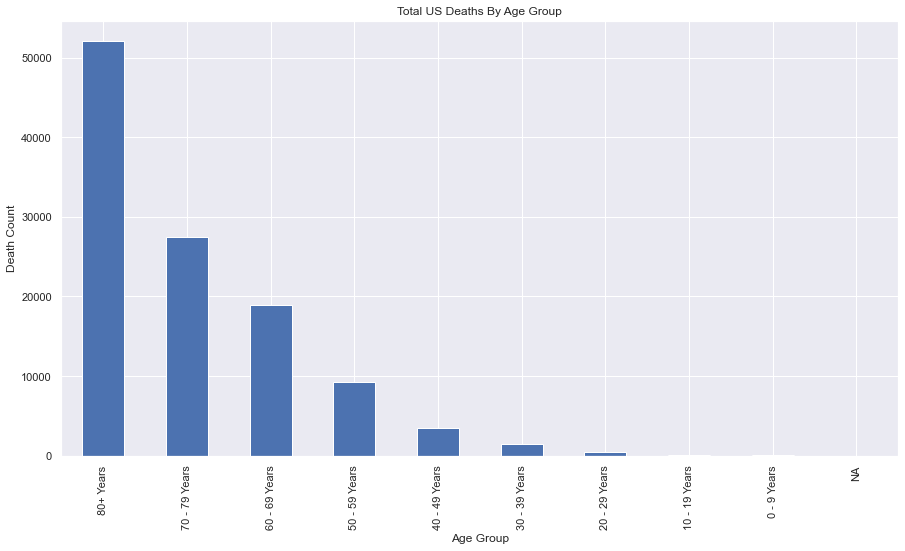

In [64]:
# DeathByAge['Raw Death Count'].plot(ylabel = 'Death Count', xlabel = 'Age Group', kind='bar', 
#                     figsize=(15,8), title = 'Total US Deaths By Age Group')

plotDeathRaw(DeathByAge['Raw Death Count'], 'Age Group', 'Total US Deaths By Age Group')

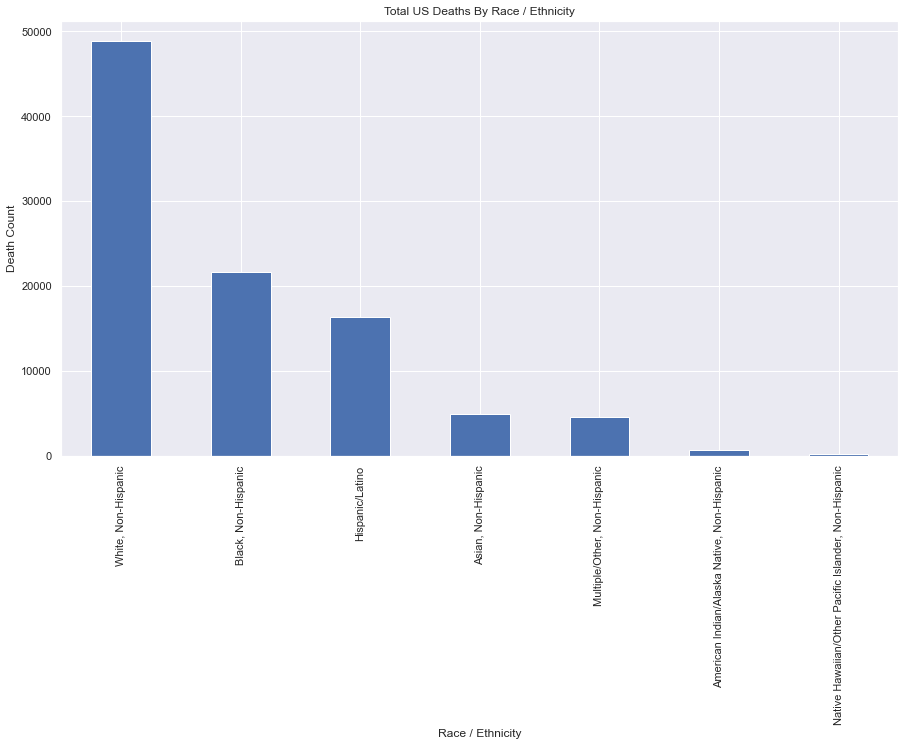

In [65]:
plotDeathRaw(DeathByEthnicity['Raw Death Count'], 'Race / Ethnicity', 'Total US Deaths By Race / Ethnicity')

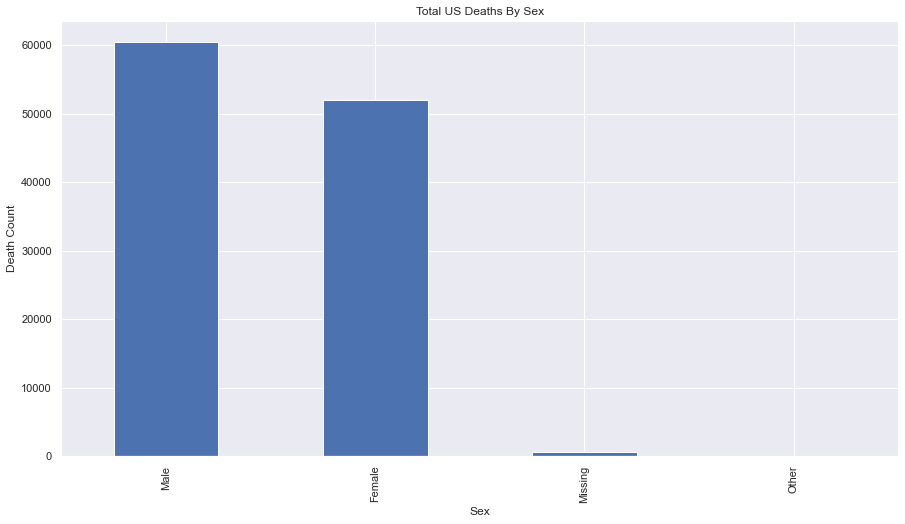

In [66]:
plotDeathRaw(DeathBySex['Raw Death Count'], 'Sex', 'Total US Deaths By Sex')